# Photometric Inference

This notebook outlines the basics of how to conduct basic redshift inference (i.e. a set of intrinsic **labels**) using **photometry** (i.e. a set of observed **features**).

# Setup

In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range

# import frankenz code
import frankenz

# plot in-line within the notebook
%matplotlib inline

np.random.seed(7)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

# Data

For our proof-of-concept tests, we will use the mock SDSS data we previously generated.

In [3]:
survey = pickle.load(open('../data/mock_sdss_cww_bpz.pkl', 'rb'))  # load data
types = survey.data['types']  # type flag
templates = survey.data['templates']  # template ID
redshifts = survey.data['redshifts']  # redshift
mags = survey.data['refmags']  # magnitude (reference)
phot_obs = survey.data['phot_obs']  # observed photometry
phot_err = survey.data['phot_err']  # photometry error
phot_true = survey.data['phot_true']  # true photometry
Nobs = len(types)

# Inference with Noisy Redshifts

For every observed galaxy $g \in \mathbf{g}$ out of $N_\mathbf{g}$ galaxies, let's assume we have an associated noisy redshift estimate $\hat{z}_g$ with PDF $P(\hat{z}_g | z)$. We are interested in constructing an estimate for the population redshift distribution $N(z|\mathbf{g})$ by projecting our results onto a relevant (possibly noisy) **redshift basis** $\lbrace \dots, P(\hat{z}_h|z) \equiv K(\hat{z}_h|z), \dots \rbrace$ indexed by $h \in \mathbf{h}$ with $N_{\mathbf{h}}$ elements. The use of $K(\cdot|\cdot)$ instead of $P(\cdot|\cdot)$ here is used to suggest the use of an underlying redshift **kernel**. We will return to this later.

Abusing notation slightly, we can write our **likelihood** between $g$ and $h$ as

$$ \mathcal{L}(g|h) \equiv P(\hat{z}_g, \hat{z}_h) = \int P(\hat{z}_g | z) K(\hat{z}_h | z) \pi(z) dz $$

where we have **marginalized** over the true redshift $z$ assuming some underlying **prior** redshift distribution $\pi(z)$. Note that the likelihood is (by construction) unnormalized so that $\sum_g \mathcal{L}(g|h) \neq 1$.

Combined with a prior over our basis $P(h)$, we can then write the **posterior** between $h$ and $g$ using **Bayes Theorem** as

$$ P(h|g) = \frac{\mathcal{L}(g|h)\pi(h)}{\mathcal{Z}_g} 
= \frac{\mathcal{L}(g|h)\pi(h)}{\sum_h \mathcal{L}(g|h) \pi(h)} $$

where $\mathcal{Z}_g$ is the **evidence** (i.e. **marginal likelihood**) of $g$.

We are interested in the number density of observed galaxies as a function of redshift, $N(z|\mathbf{g})$. Naively, we will define this as a weighted sum over our redshift basis

$$ N(z|\mathbf{g}) = \sum_h w_h(\mathbf{g}) \, K(\hat{z}_h|z) $$

where our weights

$$ w_h(\mathbf{g}) = \sum_g P(h|g) $$

are the marginal contribution to the $h$th kernel from all observed galaxies $\mathbf{g}$. The normalization of this expression is 

$$ \int N(z|\mathbf{g}) dz = \sum_h w_h(\mathbf{g}) \int K(\hat{z}_h|z) dz = \sum_h \sum_g P(h|g) = N_\mathbf{g} $$

which makes $N(z|\mathbf{g})$ a proper number density.

# Inference with Noisy Photometry

Here, we want to do this same exercise over our set of observed $N_{\mathbf{b}}$-dimensional **features** $\mathbf{F}$ with PDF $P(\hat{\mathbf{F}}|g)$. As previously, we can write our likelihood as

$$ \mathcal{L}(g|h) \equiv P(\mathbf{F}_g, \mathbf{F}_h) 
= \int P(\hat{\mathbf{F}}_g | \mathbf{F}) P(\hat{\mathbf{F}}_h | \mathbf{F}) \pi(\mathbf{F}) d\mathbf{F} $$

where $\pi(\mathbf{F})$ is now a $p$-dimensional prior over the true features. For our purposes, we will assume these set of features correspond to a set of observed **flux densities** $\hat{F}_{i,b}$ in a set of $N_{\mathbf{b}}$ **photometric bands** indexed by $b \in \mathbf{b}$.

In the case where our basis is noiseless such that $P(\hat{\mathbf{F}}_h|\mathbf{F}) = \delta(\mathbf{F}_h - \mathbf{F})$, where $\delta(\cdot)$ is the multivariate Dirac delta function, and our prior $\pi(\mathbf{F}) = 1$ is uniform, this just reduces to

$$ P(g|h) = P(\hat{\mathbf{F}}_g|\mathbf{F}_h) $$

which is just the value of the observed PDF evaluated at $\mathbf{F}_h$.

In practice, $\mathbf{g}$ constitutes a set of **unlabeled objects** with **unknown** properties while $\mathbf{h}$ is a set of **labeled objects** with **known** properties. Labeled objects might constitute a particular "training set" (in machine learning-based applications) or a set of models (in template fitting-based applications).

We are interested in inferring the redshift PDF $P(z|g)$ for our observed object $g$ based on its observed photometry $\hat{\mathbf{F}}_g$. Given our labeled objects $\mathbf{h}$ with corresponding redshift kernels $K(z|h)$, this is just

$$ 
P(z|g) = \sum_h K(z|h)P(h|g) = \frac{\sum_h K(z|h)\mathcal{L}(g|h)\pi(h)}{\sum_h \mathcal{L}(g|h)\pi(h)}
$$

which corresponds to a posterior-weighted mixture of the $K(z|h)$ redshift kernels.

# The "Big Data" Approximation

It is important to note that we've made a pretty big assumption here: **that we can reduce a continuous process over $\mathbf{F}$ to a discrete set of comparisons over our training data $\mathbf{h}$**. This choice constitutes a **"Big Data" approximation** that necessarily introduces some (Poisson) noise into our estimates, and is designed to take advantage of datasets where many ($\gtrsim 10^4$ or so) training objects are available such that our parameter space is (relatively) densely sampled. We will come back to this assumption later.

# Our Prior

In this particular case, our prior $P(h)=P(z_h,t_h,m_h)$ is defined over a series of models parameterized by magnitude, type, and redshift as described in the [Mock Data notebook](https://github.com/joshspeagle/frankenz/blob/master/demos/1%20-%20Mock%20Data.ipynb). These are saved within our original survey object and briefly shown below.

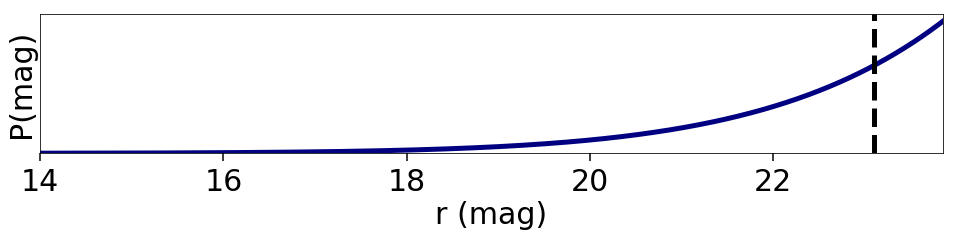

In [4]:
# plotting magnitude prior
plt.figure(figsize=(14, 4))
depths = np.array([f['depth_mag5sig'] for f in survey.filters])
mdepth = depths[survey.ref_filter]
mhigh = mdepth + 2.5 * np.log10(2)
mgrid = np.arange(14., mhigh + 0.01, 0.01)
plt.plot(mgrid, survey.pm(mgrid, mdepth), lw=5, color='navy')
plt.axvline(mdepth, ls='--', lw=5, color='black')
plt.xlabel(survey.filters[survey.ref_filter]['name'] + ' (mag)')
plt.xlim([14., mhigh])
plt.ylabel('P(mag)')
plt.ylim([0., None])
plt.yticks([])
plt.tight_layout()

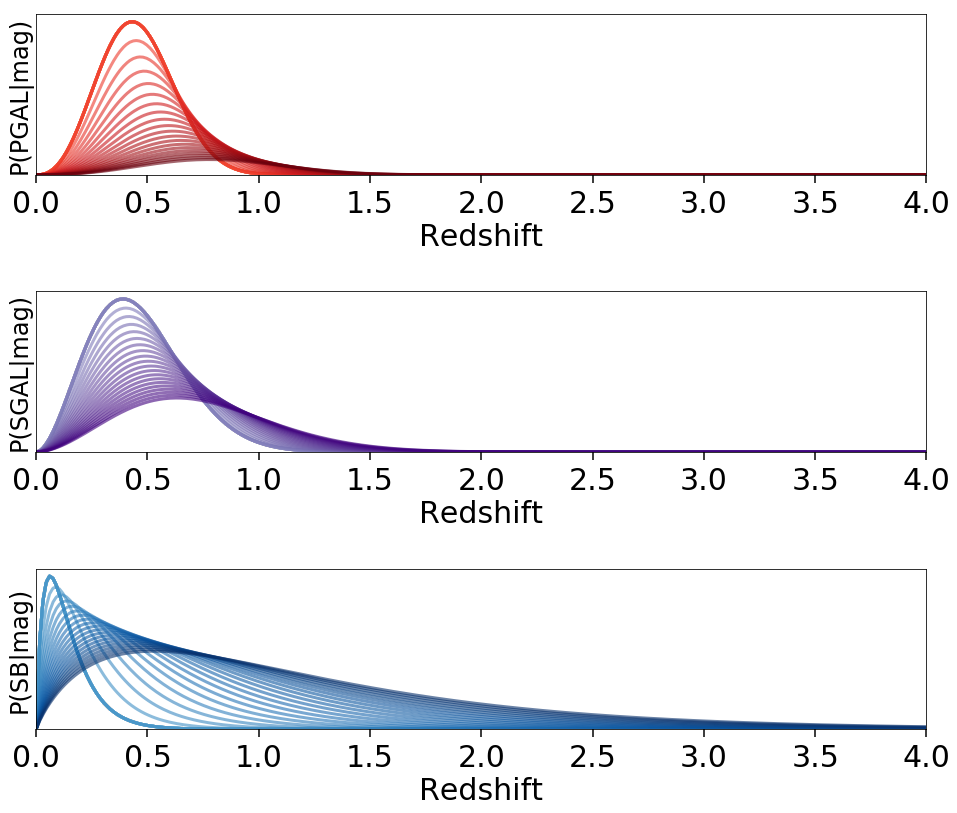

In [5]:
# plotting prior
mgrid_sub = mgrid[::20]
Nmag = len(mgrid_sub)
zgrid = np.linspace(0., 4., 1000)
pgal_colors = plt.get_cmap('Reds')(np.linspace(0, 1, Nmag))  # PGAL colors
sgal_colors = plt.get_cmap('Purples')(np.linspace(0, 1, Nmag))  # SGAL colors
sb_colors = plt.get_cmap('Blues')(np.linspace(0, 1, Nmag))  # SB colors

plt.figure(figsize=(14, 12))
for i, color in zip(range(survey.NTYPE), [pgal_colors, sgal_colors, sb_colors]):
    plt.subplot(3,1,i+1)
    for j, c in zip(mgrid_sub, color):
        pztm = [survey.pztm(z, i, j) for z in zgrid]
        plt.plot(zgrid, pztm, lw=3, color=c, alpha=0.6)
    plt.xlabel('Redshift')
    plt.xlim([0, 4])
    plt.ylabel('P({0}|mag)'.format(survey.TYPES[i]), fontsize=24)
    plt.ylim([0., None])
    plt.yticks([])
    plt.tight_layout()

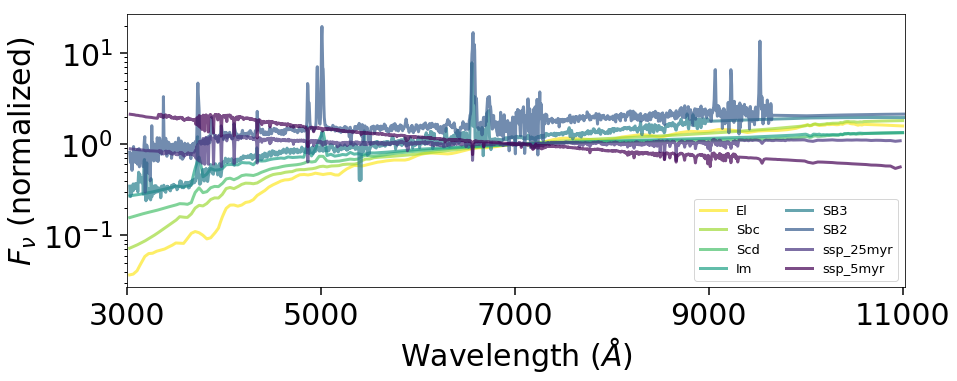

In [6]:
# plotting templates
tcolors = plt.get_cmap('viridis_r')(np.linspace(0., 1., survey.NTEMPLATE)) # template colors
xlow = min([min(f['wavelength']) for f in survey.filters])  # lower bound
xhigh = max([max(f['wavelength']) for f in survey.filters])  # upper bound
plt.figure(figsize=(14, 6))
for t, c in zip(survey.templates, tcolors):
    wave, fnu, name = t['wavelength'], t['fnu'], t['name']
    sel = (wave > xlow) & (wave < xhigh)
    plt.semilogy(wave[sel], fnu[sel], lw=3, color=c,
                 label=name, alpha=0.7)
plt.xlim([xlow, xhigh])
plt.xticks(np.arange(3000., 11000.+1., 2000.))
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'$F_{\nu}$ (normalized)')
plt.legend(ncol=int(survey.NTEMPLATE/6 + 1), fontsize=13, loc=4)
plt.tight_layout()

# Photometric Likelihoods

For most galaxies, we can take $P(\hat{\mathbf{F}}_i|\mathbf{F})$ to be a **multivariate Normal** (i.e. Gaussian) distribution such that

$$ 
P(\hat{\mathbf{F}}_i|\mathbf{F}) = \mathcal{N}(\hat{\mathbf{F}}_i|\mathbf{F},\mathbf{C}_i) 
\equiv \frac{\exp\left[-\frac{1}{2}||\hat{\mathbf{F}}_i-\mathbf{F}||_{\mathbf{C}_i}^2\right]}{(2\pi)^{N_\mathbf{b}/2}|\mathbf{C}_i|^{1/2}} 
$$

where

$$ 
||\hat{\mathbf{F}}_i-\mathbf{F}||_{\mathbf{C}_i}^2 \equiv (\hat{\mathbf{F}}_i-\mathbf{F})^{\rm T}\mathbf{C}_i^{-1}(\hat{\mathbf{F}}_i-\mathbf{F}) 
$$

is the **squared Mahalanobis distance** between $\hat{\mathbf{F}}_i$ and $\mathbf{F}$ given **covariance matrix** $\mathbf{C}_i$ (i.e. the photometric errors), ${\rm T}$ is the transpose operator, and $|\mathbf{C}_i|$ is the **determinant** of $\mathbf{C}_g$.

While we will use matrix notation for compactness, in practice we will assume all our covariances are diagonal (i.e. the errors are independent) such that

$$
||\hat{\mathbf{F}}_g-\mathbf{F}||_{\mathbf{C}_g}^2 = \sum_{b} \frac{(\hat{F}_{g,b}-F_b)^2}{\sigma^2_{g,b}}
$$

## Likelihood: Magnitudes (Scale-dependent)

We first look at the simplest case: a direct observational comparison over $\mathbf{F}$ (i.e. galaxy **magnitudes**).

The product of two multivariate Normal distributions $\mathcal{N}(\hat{\mathbf{F}}_g|\mathbf{F},\mathbf{C}_g)$ and $\mathcal{N}(\hat{\mathbf{F}}_h|\mathbf{F},\mathbf{C}_h)$ is a scaled multivariate Normal of the form $S_{gh}\,\mathcal{N}(\mathbf{F}_{gh}|\mathbf{F},\mathbf{C}_{gh})$ where

$$
S_{gh} \equiv \mathcal{N}(\hat{\mathbf{F}}_g|\hat{\mathbf{F}}_h, \mathbf{C}_g + \mathbf{C}_h), \quad 
\mathbf{F}_{gh} \equiv \mathbf{C}_{gh} \left( \mathbf{C}_g^{-1}\mathbf{F}_g 
+ \mathbf{C}_h^{-1}\mathbf{F}_h \right), \quad
\mathbf{C}_{gh} \equiv \left(\mathbf{C}_g^{-1} + \mathbf{C}_h^{-1}\right)^{-1}
$$

If we assume a uniform prior on our flux densities $P(\mathbf{F})=1$, our likelihood then becomes

$$ \mathcal{L}(g|h) = \int P(\hat{\mathbf{F}}_g | \mathbf{F}) P(\hat{\mathbf{F}}_h | \mathbf{F}) 
\pi(\mathbf{F}) d\mathbf{F} 
= S_{gh} \int \mathcal{N}(\mathbf{F}_{gh}|\mathbf{F},\mathbf{C}_{gh}) d\mathbf{F}
= S_{gh} $$

The log-likelihood can then be written as

\begin{equation}
\boxed{
-2\ln \mathcal{L}(g|h) = ||\mathbf{F}_g - \mathbf{F}_h||_{\mathbf{C}_{g} + \mathbf{C}_{h}}^2 + N_\mathbf{b}\ln(2\pi) + \ln|\mathbf{C}_{g} + \mathbf{C}_{h}|
}
\end{equation}

Let's compute an example PDF using `frankenz` for objects in our mock catalog. Since these are sampled from the prior, we've actually introduced our prior **implicitly via the distribution of objects in our labeled sample**. As a result, computing likelihoods directly in magnitudes actually probes (with some noise) the full posterior distribution (as defined by BPZ).

We will compare two versions of our results: 
- **Noiseless case**: computed using the "true" underlying photometry underlying each training object.
- **Noisy case**: computed using our "observed" mock photometry.

In [7]:
# sample good example object
idx = np.random.choice(np.arange(Nobs)[(mags < 22.5) & (mags > 22)])

In [8]:
# compute loglikelihoods (noiseless) 
ll, nb, chisq = frankenz.pdf.loglike(phot_obs[idx], phot_err[idx],
                                     np.ones(survey.NFILTER),
                                     phot_true, phot_err,
                                     np.ones_like(phot_true),
                                     free_scale=False, ignore_model_err=True,
                                     dim_prior=False)

# compute loglikelihoods (noisy)
ptemp = np.random.normal(phot_true, phot_err)  # re-jitter to avoid exact duplicates
ll2, nb2, chisq2 = frankenz.pdf.loglike(phot_obs[idx], phot_err[idx], 
                                        np.ones(survey.NFILTER),
                                        ptemp, phot_err, 
                                        np.ones_like(phot_true),
                                        free_scale=False, ignore_model_err=False,
                                        dim_prior=False)

Note that the log-likelihood function defined in `frankenz` contains a number of additional options that have been specified above. These will be discussed later.

In [9]:
# define plotting functions
try:
    from scipy.special import logsumexp
except ImportError:
    from scipy.misc import logsumexp

def plot_flux(phot_obs, phot_err, phot, logl, 
              ocolor='black', mcolor='blue', thresh=1e-1):
    """Plot SEDs."""

    wave = np.array([f['lambda_eff'] for f in survey.filters])
    wt = np.exp(logl)
    wtmax = wt.max()
    sel = np.arange(len(phot))[wt > thresh * wtmax]
    [plt.plot(wave, phot[i], alpha=wt[i]/wtmax*0.4, lw=3, 
              zorder=1, color=mcolor) for i in sel]
    plt.errorbar(wave, phot_obs, yerr=phot_err, lw=3, color=ocolor, zorder=2)
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.xlim([wave.min() - 100, wave.max() + 100])
    plt.ylim([(phot_obs - phot_err).min() * 0.9, (phot_obs + phot_err).max() * 1.1])
    plt.ylabel(r'$F_\nu$')
    plt.yticks(fontsize=24)
    plt.tight_layout()
    
def plot_redshift(redshifts, logl, ztrue=None, color='yellow', 
                  tcolor='red'):
    """Plot redshift PDF."""
    
    n, _, _ = plt.hist(redshifts, bins=zgrid, weights=np.exp(logl), 
                       histtype='stepfilled', edgecolor='black',
                       lw=3, color=color, alpha=0.8)
    if ztrue is not None:
        plt.vlines(ztrue, 0., n.max() * 1.1, color=tcolor, linestyles='--', lw=2)
    plt.xlabel('Redshift')
    plt.ylabel('PDF')
    plt.xlim([zgrid[0], zgrid[-1]])
    plt.ylim([0., n.max() * 1.1])
    plt.yticks([])
    plt.tight_layout()

def plot_zt(redshifts, templates, logl, ztrue=None, ttrue=None,
            cmap='viridis', tcolor='red', thresh=1e-2):
    """Plot joint template-redshift PDF."""
    lsum = logsumexp(logl)
    wt = np.exp(logl - lsum)
    plt.hist2d(redshifts, templates, bins=[zgrid, tgrid],
               weights=wt, 
               cmin=thresh*max(wt),
               cmap=cmap)
    if ttrue is not None:
        plt.hlines(ttrue, zgrid.min(), zgrid.max(), 
                   color=tcolor, lw=2, linestyles='--')
    if ztrue is not None:
        plt.vlines(ztrue, tgrid.min(), tgrid.max(), 
                   color=tcolor, lw=2, linestyles='--')
    plt.xlabel('Redshift')
    plt.ylabel('Template')
    plt.xlim([zgrid[0], zgrid[-1]])
    plt.ylim([tgrid[0], tgrid[-1]])
    plt.tight_layout()

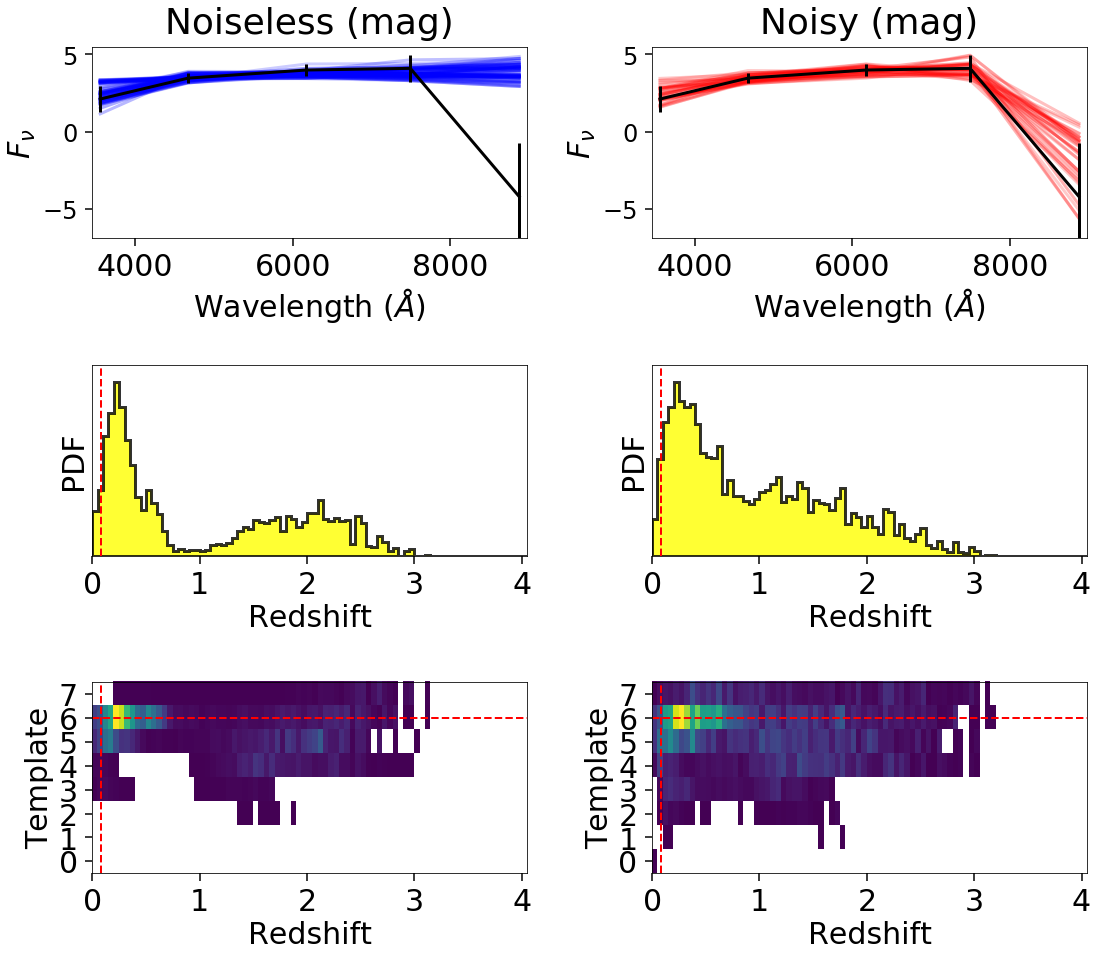

In [10]:
# plot flux distribution
plt.figure(figsize=(16, 14))
plt.subplot(3,2,1)
plot_flux(phot_obs[idx], phot_err[idx], phot_true, ll, 
          ocolor='black', mcolor='blue', thresh=0.5)
plt.title('Noiseless (mag)', y=1.04)
plt.subplot(3,2,2)
plot_flux(phot_obs[idx], phot_err[idx], ptemp, ll2, 
          ocolor='black', mcolor='red', thresh=0.5)
plt.title('Noisy (mag)', y=1.04);

# plot redshift distribution
zgrid = np.arange(0., 4. + 0.1, 0.05)
plt.subplot(3,2,3)
plot_redshift(redshifts, ll, ztrue=redshifts[idx])
plt.xticks(zgrid[::20])
plt.subplot(3,2,4)
plot_redshift(redshifts, ll2, ztrue=redshifts[idx])
plt.xticks(zgrid[::20])

# plot redshift-type joint distribution
tgrid = np.arange(survey.NTEMPLATE + 1) - 0.5
plt.subplot(3,2,5)
plot_zt(redshifts, templates, ll,
        ztrue=redshifts[idx], ttrue=templates[idx])
plt.xticks(zgrid[::20])
plt.yticks(tgrid[1:] - 0.5)
plt.subplot(3,2,6)
plot_zt(redshifts, templates, ll2,
        ztrue=redshifts[idx], ttrue=templates[idx])
plt.xticks(zgrid[::20])
plt.yticks(tgrid[1:] - 0.5);

As expected, the PDF computed from our noisy photometry is broader than than the noiseless case.

## Likelihood: Colors

We can also defined our likelihoods in terms of **flux ratios** (i.e. galaxy **"colors"**) by introducing a scaling parameter $\ell$. Assuming $P(\mathbf{F},\ell) = 1$ is uniform this takes the form

$$
\mathcal{L}_\ell(g|h) = \int \mathcal{N}\left(\hat{\mathbf{F}}_g | \ell\hat{\mathbf{F}}_h, \mathbf{C}_{g}+\ell^2\mathbf{C}_{h} \right)\,d\ell
$$

Although this integral does not have an analytic solution, we can numerically solve for the maximum-likelihood result $\mathcal{L}(g|h, \ell_{\rm ML})$. See [Leistedt & Hogg (2017)](http://adsabs.harvard.edu/abs/2017ApJ...838....5L) for some additional discussion related to this integral.

If we assume, however, that $\mathbf{C}_h = \mathbf{0}$ (i.e. no model errors), then there *is* an analytic solution with log-likelihood

\begin{equation}
\boxed{
-2\ln \mathcal{L}_\ell(g|h) = ||\hat{\mathbf{F}}_g - \ell_{\rm ML}\hat{\mathbf{F}}_h||_{\mathbf{C}_{g}}^2 + N_\mathbf{b}\ln(2\pi) + \ln|\mathbf{C}_{g}|
}
\end{equation}

where

$$
\ell_{\rm ML} = \frac{\hat{\mathbf{F}}_g^{\rm T} \mathbf{C}_g^{-1} \hat{\mathbf{F}}_h}
{\hat{\mathbf{F}}_h^{\rm T} \mathbf{C}_g^{-1} \hat{\mathbf{F}}_h}
$$

We can now repeat the above exercise using our color-based likelihoods. As above, we compare two versions:
- **Noiseless case**: computed using the "true" underlying photometry underlying each training object.
- **Noisy case**: computed using our "observed" mock photometry.

In [11]:
# compute color loglikelihoods (noiseless)
llc, nbc, chisq, s, serr = frankenz.pdf.loglike(phot_obs[idx], phot_err[idx], 
                                                np.ones(survey.NFILTER),
                                                phot_true, phot_err, 
                                                np.ones_like(phot_true), 
                                                dim_prior=False, free_scale=True, 
                                                ignore_model_err=True, return_scale=True)

# compute color loglikelihoods (noisy)
llc2, nbc2, chisq2, s2, serr2 = frankenz.pdf.loglike(phot_obs[idx], phot_err[idx], 
                                                     np.ones(survey.NFILTER),
                                                     ptemp, phot_err, 
                                                     np.ones_like(phot_true), 
                                                     dim_prior=False, free_scale=True, 
                                                     ignore_model_err=False, return_scale=True)

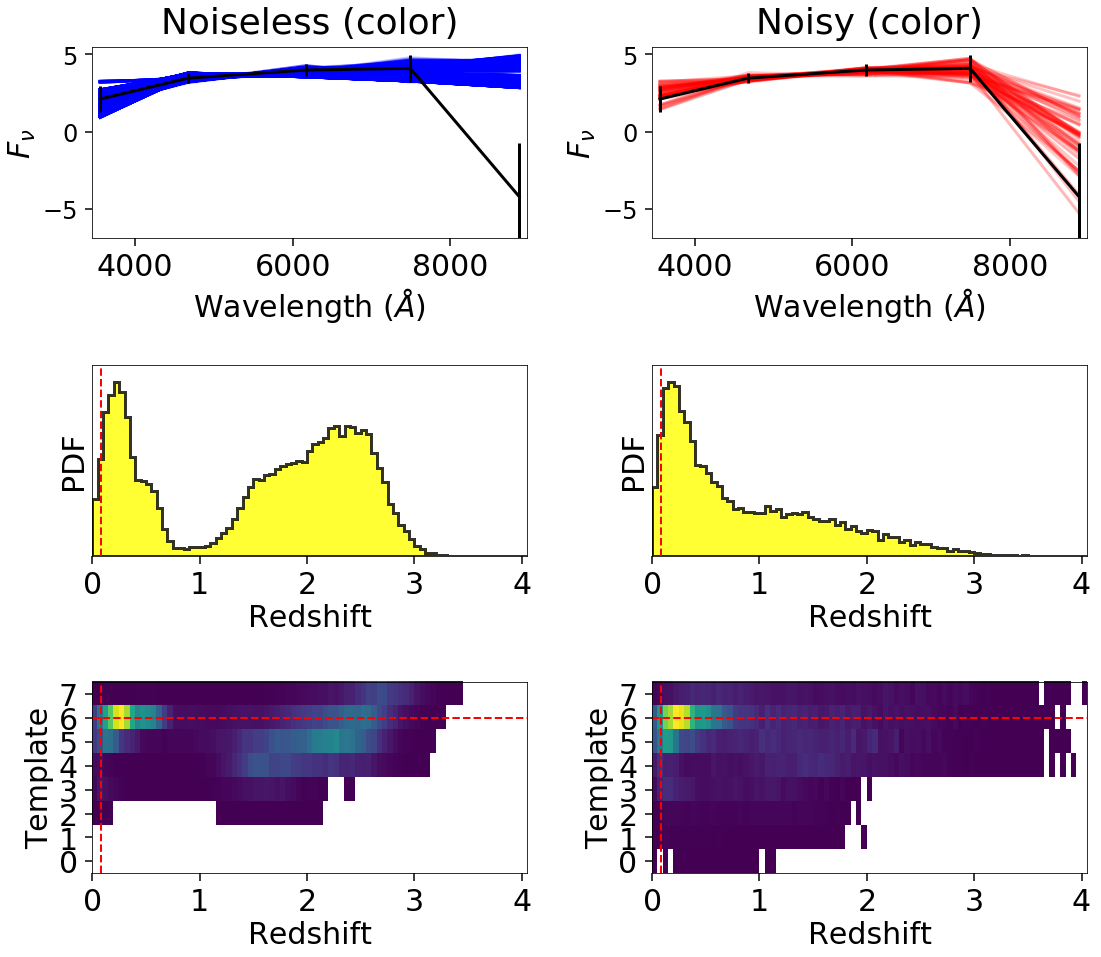

In [12]:
# plot flux distribution
plt.figure(figsize=(16, 14))
plt.subplot(3,2,1)
plot_flux(phot_obs[idx], phot_err[idx], s[:, None] * phot_true,
          llc, ocolor='black', mcolor='blue', thresh=0.5)
plt.title('Noiseless (color)', y=1.04)
plt.subplot(3,2,2)
plot_flux(phot_obs[idx], phot_err[idx], s2[:, None] * ptemp,
          llc2, ocolor='black', mcolor='red', thresh=0.5)
plt.title('Noisy (color)', y=1.04);

# plot redshift distribution
plt.subplot(3,2,3)
plot_redshift(redshifts, llc, ztrue=redshifts[idx])
plt.xticks(zgrid[::20])
plt.subplot(3,2,4)
plot_redshift(redshifts, llc2, ztrue=redshifts[idx])
plt.xticks(zgrid[::20])

# plot redshift-type joint distribution
plt.subplot(3,2,5)
plot_zt(redshifts, templates, llc, thresh=1e-2,
        ztrue=redshifts[idx], ttrue=templates[idx])
plt.xticks(zgrid[::20])
plt.yticks(tgrid[1:] - 0.5)
plt.subplot(3,2,6)
plot_zt(redshifts, templates, llc2, thresh=1e-2,
        ztrue=redshifts[idx], ttrue=templates[idx])
plt.xticks(zgrid[::20])
plt.yticks(tgrid[1:] - 0.5);

Finally, it's useful to compare the case where we compute our posteriors directly from our underlying model grid and apply our priors directly. By construction, this should agree with the "true" posterior distribution up to the approximation that for a given template $t$ and redshift $z$ we can take the model to have a magnitude based on $\ell_{\rm ML}$ rather than integrating over the full $\pi(\ell)$ distribution, i.e.

$$
\mathcal{L}_\ell(g|h) = \int \pi(\ell) \mathcal{N}\left(\hat{\mathbf{F}}_g | \ell\hat{\mathbf{F}}_h, \mathbf{C}_{g}+\ell^2\mathbf{C}_{h} \right)\,d\ell \approx \pi(\ell_{\rm ML}) \mathcal{L}(g|h, \ell_{\rm ML})
$$

In [13]:
# compute color loglikelihoods over grid
mphot = survey.models['data'].reshape(-1, survey.NFILTER)
merr = np.zeros_like(mphot)
mmask = np.ones_like(mphot)
llm, nbm, chisqm, sm, smerr = frankenz.pdf.loglike(phot_obs[idx], phot_err[idx], 
                                                   np.ones(survey.NFILTER),
                                                   mphot, merr, mmask,
                                                   dim_prior=False, free_scale=True, 
                                                   ignore_model_err=True, return_scale=True)

In [14]:
# compute prior
mzgrid = survey.models['zgrid']
prior = np.array([frankenz.priors.bpz_pz_tm(mzgrid, t, mags[idx]) 
                  for t in survey.TTYPE]).T.flatten()

/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log
/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in log


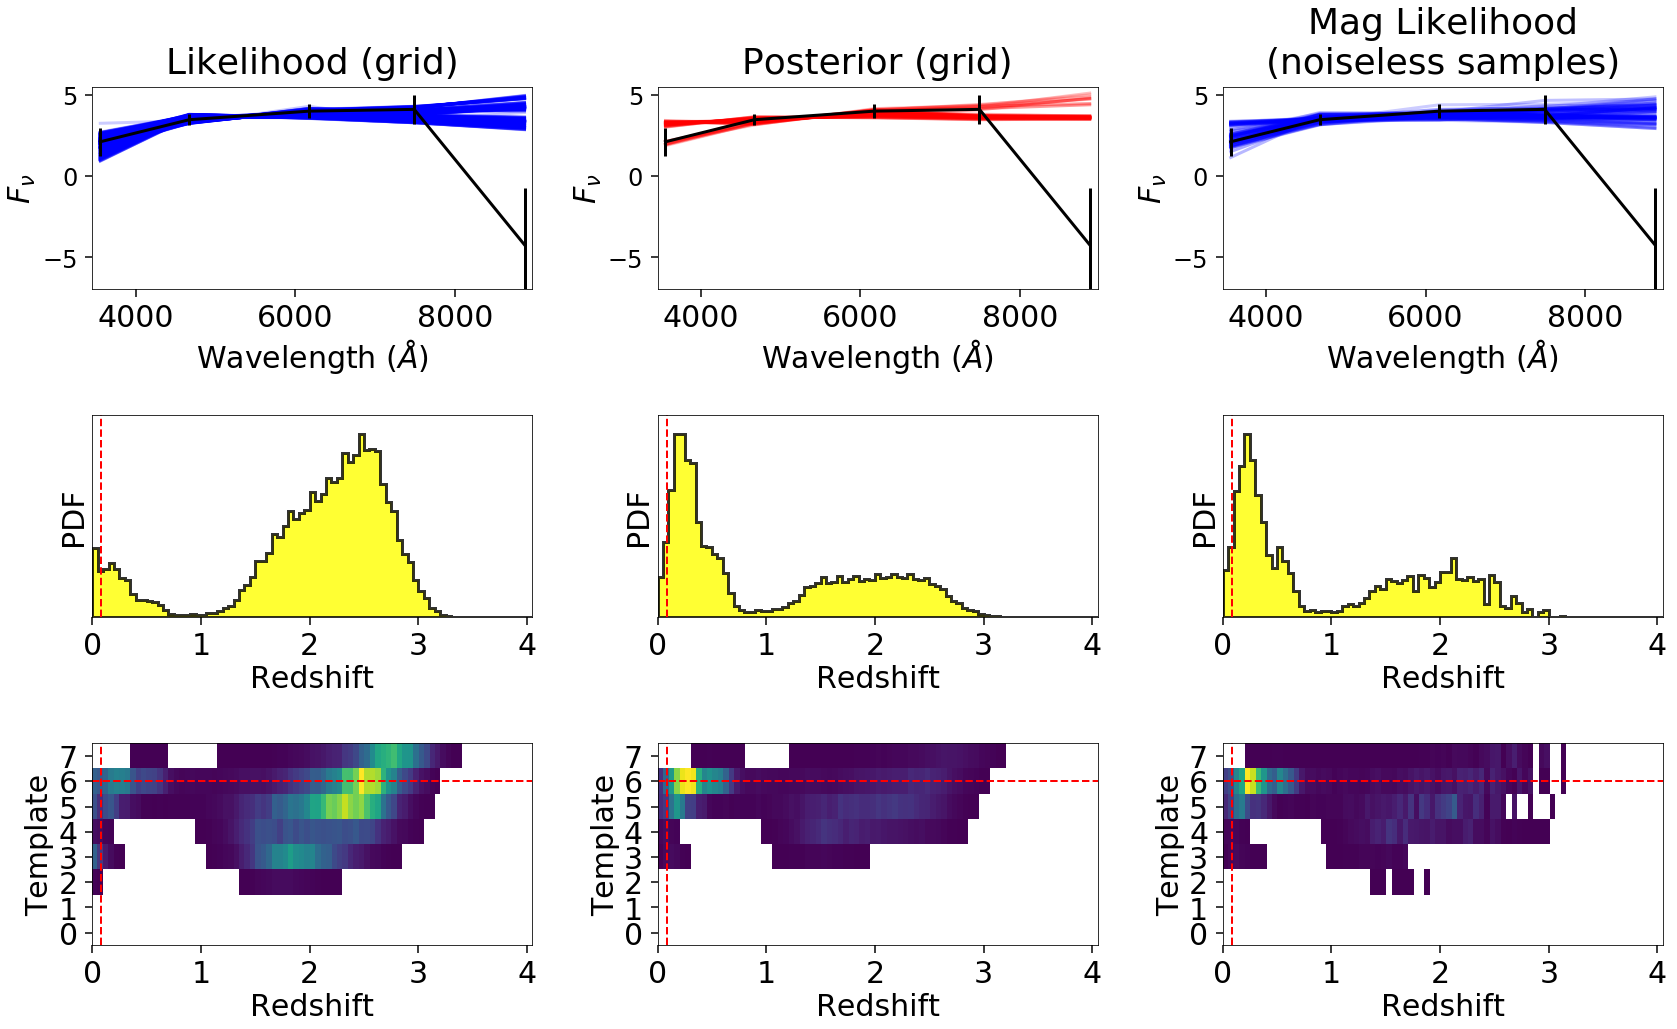

In [15]:
# plot flux distribution
plt.figure(figsize=(24, 15))
plt.subplot(3,3,1)
plot_flux(phot_obs[idx], phot_err[idx], sm[:, None] * mphot,
          llm, ocolor='black', mcolor='blue', thresh=0.5)
plt.title('Likelihood (grid)', y=1.04)
plt.subplot(3,3,2)
plot_flux(phot_obs[idx], phot_err[idx], sm[:, None] * mphot,
          llm + np.log(prior).flatten(), 
          ocolor='black', mcolor='red', thresh=0.5)
plt.title('Posterior (grid)', y=1.04)
plt.subplot(3,3,3)
plot_flux(phot_obs[idx], phot_err[idx], phot_true, ll, 
          ocolor='black', mcolor='blue', thresh=0.5)
plt.title('Mag Likelihood\n(noiseless samples)', y=1.04)

# plot redshift distribution
mredshifts = np.array([mzgrid for i in range(survey.NTEMPLATE)]).T.flatten()
plt.subplot(3,3,4)
plot_redshift(mredshifts, llm, ztrue=redshifts[idx])
plt.xticks(zgrid[::20])
plt.subplot(3,3,5)
plot_redshift(mredshifts, llm + np.log(prior).flatten(),
              ztrue=redshifts[idx])
plt.xticks(zgrid[::20])
plt.subplot(3,3,6)
plot_redshift(redshifts, ll, ztrue=redshifts[idx])
plt.xticks(zgrid[::20])

# plot redshift-type joint distribution
mtemplates = np.array([np.arange(survey.NTEMPLATE) 
                       for i in range(len(mzgrid))]).flatten()
plt.subplot(3,3,7)
plot_zt(mredshifts, mtemplates, llm, thresh=1e-2,
        ztrue=redshifts[idx], ttrue=templates[idx])
plt.xticks(zgrid[::20])
plt.yticks(tgrid[1:] - 0.5)
plt.subplot(3,3,8)
plot_zt(mredshifts, mtemplates, llm + np.log(prior).flatten(),
        thresh=1e-2, ztrue=redshifts[idx], ttrue=templates[idx])
plt.xticks(zgrid[::20])
plt.yticks(tgrid[1:] - 0.5)
plt.subplot(3,3,9)
plot_zt(redshifts, templates, ll,
        ztrue=redshifts[idx], ttrue=templates[idx])
plt.xticks(zgrid[::20])
plt.yticks(tgrid[1:] - 0.5);

As expected, the secondary solutions seen in our grid-based likelihoods are suppressed by our prior, which indicates many of these solutions are distinctly unphysical (at least given the original assumptions used when constructing our mock).

In addition, the BPZ posterior computed over our grid of models agrees quite well with the noiseless magnitude-based likelihoods computed over our noiseless samples (i.e. our labeled "training" data). This demonstrates that an utilizing an unbiased, representative training set instead of a grid of models inherently gives access to complex priors that otherwise have to be modeled analytically. In other words, we can take $P(h) = 1$ for all $h \in \mathbf{h}$ since the distribution of our labeled photometric samples probes the underlying $P(z, t, m)$ distribution.

In practice, however, we do not often have access to a fully representative training sample, and often must derive an estimate of $P(\mathbf{h})$ through other means. We will return to this point later.

# Population Tests

We now want to see how things look on a larger sample of objects.

In [16]:
sel = (phot_obs / phot_err)[:, survey.ref_filter] > 5.  # S/N > 5 cut
Nsel = sel.sum()

Ntrain, Ntest = 60000, 5000
train_sel = np.arange(Nobs)[sel][:Ntrain]  # training set
test_sel = np.arange(Nobs)[sel][Ntrain:Ntrain+Ntest]  # testing set
Nmodel = len(mphot)

print('Number of observed galaxies (all):', Nobs)
print('Number of observed galaxies (selected):', Nsel)
print('Number of models:', Nmodel)
print('Number of training galaxies:', Ntrain)
print('Number of testing galaxies:', Ntest)

Number of observed galaxies (all): 200000
Number of observed galaxies (selected): 67951
Number of models: 8000
Number of training galaxies: 60000
Number of testing galaxies: 5000


## Sidenote: KDE in `frankenz`

One of the ways `frankenz` differs from other photometric redshift (photo-z) codes is that it tries to avoid discretizing quantities whenever and wherever possible. Since redshifts, flux densities, and many other photometric quantities are **continuous with smooth PDFs**, we attempt to work directly in this continuous space whenever possible instead of resorting to binning.

We accomplish this through **kernel density estimation (KDE)**. Since almost all photometric observable PDFs are Gaussian, by connecting each observable with an associated Gaussian kernel density we can (in theory) construct a density estimate at any location in parameter space by evaluating the probability density of all kernels at that location.

In practice, such a brute-force approach is prohibitively computationally expensive. Instead, we approximate the contribution from any particular object by:

1. evaluating only a small subset of "nearby" kernels, 
2. evaluating the overall kernel density estimates over a discrete basis, and 
3. evaluating only the "central regions" of our kernels. 

This is implemented within the `gauss_kde` function in `frankenz`'s `pdf` module.

In addition, we can also use a stationary **pre-computed dictionary** of Gaussian kernels to discretize our operations. This avoids repetitive, expensive computations at the (very small) cost of increased memory overhead and errors from imposing a minimum resolution. This is implemented via the `PDFDict` class and the `gauss_kde_dict` function. We will use the option whenever possible going forward.

## Magnitude Distribution

Let's use this functionality to visualize the stacked magnitude distribution of our population.

In [17]:
# initialize asinh magnitudes ("Luptitudes")
flux_zeropoint = 10**(-0.4 * -23.9) # AB magnitude zeropoint
fdepths = np.array([f['depth_flux1sig'] for f in survey.filters])
mag, magerr = frankenz.pdf.luptitude(phot_obs, phot_err, skynoise=fdepths,
                                     zeropoints=flux_zeropoint)

# initialize magnitude dictionary 
mdict = frankenz.pdf.PDFDict(pdf_grid=np.arange(-20., 60., 5e-3), 
                             sigma_grid=np.linspace(0.01, 5., 500))

Note that we've used asinh magnitudes (i.e. "Luptitudes"; [Lupton et al. 1999](http://adsabs.harvard.edu/abs/1999AJ....118.1406L)) rather than $\log_{10}$ magnitudes in order to incorporate data with negative measured fluxes.

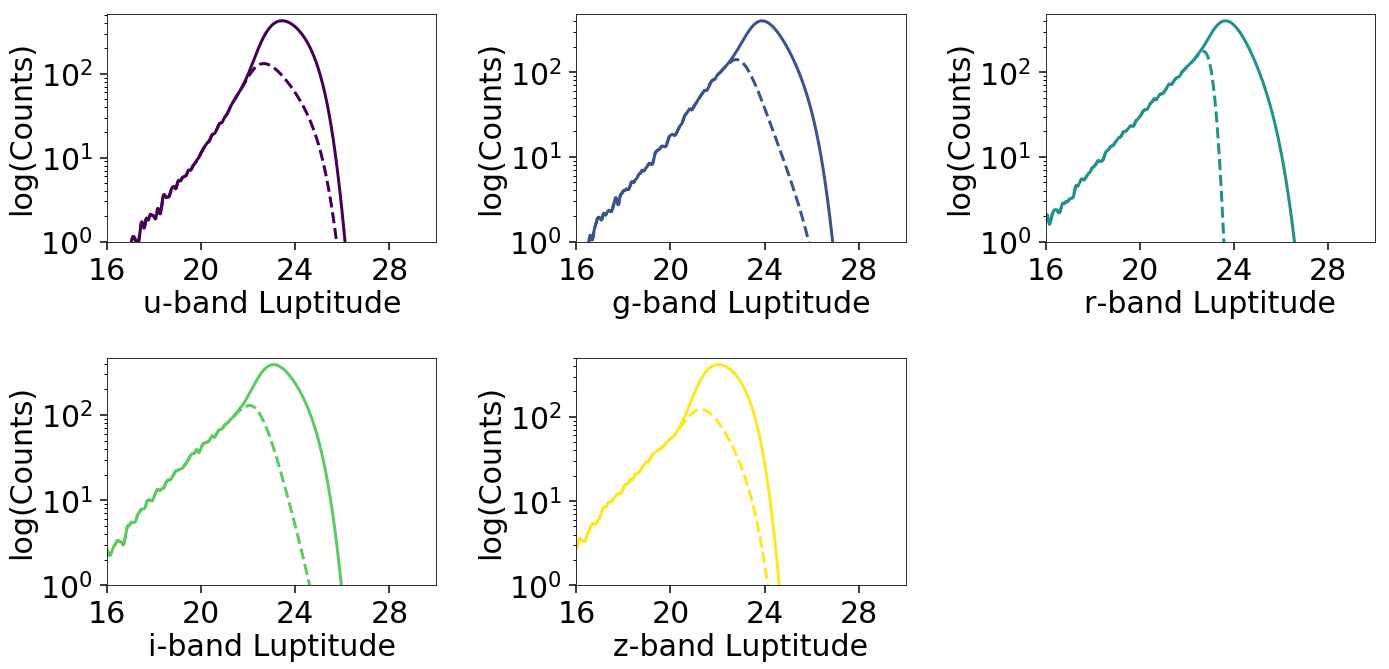

In [18]:
# plotting magnitude distribution
msmooth = 0.05
fcolors = plt.get_cmap('viridis')(np.linspace(0,1, survey.NFILTER))
plt.figure(figsize=(20, 10))
for i in range(survey.NFILTER):
    plt.subplot(2, int(survey.NFILTER/2)+1, i+1)
    
    # compute pdf (all)
    magerr_t = np.sqrt(magerr[:, i]**2 + msmooth**2)
    mag_pdf = frankenz.pdf.gauss_kde_dict(mdict, y=mag[:, i],
                                          y_std=magerr_t)
    plt.semilogy(mdict.grid, mag_pdf, lw=3, color=fcolors[i])
    
    # compute pdf (selected)
    magsel_pdf = frankenz.pdf.gauss_kde_dict(mdict, y=mag[sel, i],
                                             y_std=magerr_t[sel])
    plt.semilogy(mdict.grid, magsel_pdf, lw=3, color=fcolors[i], ls='--')
    
    # prettify
    plt.xlim([16, 30])
    plt.ylim([1., mag_pdf.max() * 1.2])
    plt.xticks(np.arange(16, 30, 4))
    plt.xlabel(survey.filters[i]['name'] + '-band Luptitude')
    plt.ylabel('log(Counts)')
    plt.tight_layout()

Note that, by default, all KDE options implemented in `frankenz` use some type of thresholding/clipping to avoid including portions of the PDFs with negligible weight and objects with negligible contributions to the overall stacked PDF. The default option is **weight thresholding**, where objects with $w < f_\min w_\max$ are excluded (with $f_\min = 10^{-3}$ by default). An alternative option is **CDF thresholding**, where objects that make up the $1 - c_\min$ portion of the sorted CDF are excluded (with $c_\min = 2 \times 10^{-4}$ by default). See the documentation for more details.

## Redshift Distribution

Let's now compute our effective $N(z|\mathbf{g})$.

In [19]:
# initialize redshift dictionary
rdict = frankenz.pdf.PDFDict(pdf_grid=np.arange(0., 7.+1e-5, 0.01), 
                             sigma_grid=np.linspace(0.005, 2., 500))

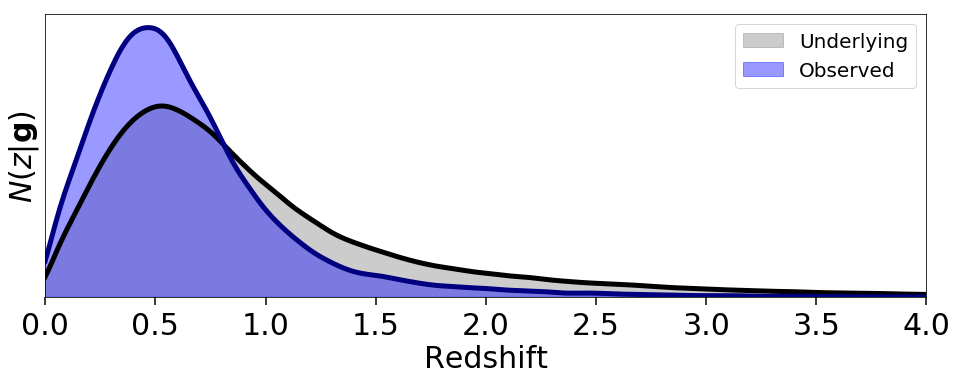

In [20]:
# plotting redshift distribution
plt.figure(figsize=(14, 6))
rsmooth = 0.05

# all
zerr_t = np.ones_like(redshifts) * rsmooth
z_pdf = frankenz.pdf.gauss_kde_dict(rdict, y=redshifts,
                                    y_std=zerr_t)
plt.plot(rdict.grid, z_pdf / z_pdf.sum(), lw=5, color='black')
plt.fill_between(rdict.grid, z_pdf / z_pdf.sum(), color='gray',
                 alpha=0.4, label='Underlying')

# selected
zsel_pdf = frankenz.pdf.gauss_kde_dict(rdict, y=redshifts[sel],
                                       y_std=zerr_t[sel])
plt.plot(rdict.grid, zsel_pdf / zsel_pdf.sum(), lw=5, color='navy')
plt.fill_between(rdict.grid, zsel_pdf / zsel_pdf.sum(), 
                 color='blue', alpha=0.4, label='Observed')

# prettify
plt.xlim([0, 4])
plt.ylim([0, None])
plt.yticks([])
plt.legend(fontsize=20)
plt.xlabel('Redshift')
plt.ylabel('$N(z|\mathbf{g})$')
plt.tight_layout()

# Comparison 1: Mag (samples) vs Color (grid)

As a first proof of concept, we want to just check whether the population distribution inferred from our samples (using magnitudes) agree with those inferred from our underlying model grid (using colors).

In [21]:
# initialize datasets
phot_train, phot_test = phot_obs[train_sel], phot_obs[test_sel]
err_train, err_test = phot_err[train_sel], phot_err[test_sel]
mask_train, mask_test = np.ones_like(phot_train), np.ones_like(phot_test)

To fit these objects, we will take advantage of the `BruteForce` object available through `frankenz`'s `fitting` module.

In [22]:
from frankenz.fitting import BruteForce

# initialize BruteForce objects
model_BF = BruteForce(mphot, merr, mmask)  # model grid
train_BF = BruteForce(phot_train, err_train, mask_train)  # training data

In [23]:
# define log(posterior) functions

def lprob_bpz(x, xe, xm, ys, yes, yms, 
              mzgrid=None, ttypes=None, ref=None):
    results = frankenz.pdf.loglike(x, xe, xm, ys, yes, yms,
                                   ignore_model_err=True, 
                                   free_scale=True)
    lnlike, ndim, chi2 = results
    mag = -2.5 * np.log10(x[ref]) + 23.9
    prior = np.array([frankenz.priors.bpz_pz_tm(mzgrid, t, mag)
                      for t in ttypes]).T.flatten()
    lnprior = np.log(prior)
    return lnprior, lnlike, lnlike + lnprior, ndim, chi2

def lprob_train(x, xe, xm, ys, yes, yms):
    results = frankenz.pdf.loglike(x, xe, xm, ys, yes, yms)
    lnlike, ndim, chi2 = results
    return 0., lnlike, lnlike, ndim, chi2

We'll start by fitting our model grid and generating posterior and likelihood-weighted redshift predictions.

In [24]:
# fit data
model_BF.fit(phot_test, err_test, mask_test, lprob_func=lprob_bpz, 
             lprob_args=[mzgrid, survey.TTYPE, survey.ref_filter])

# compute posterior-weighted redshift PDFs
mredshifts = np.array([mzgrid for i in range(survey.NTEMPLATE)]).T.flatten()
pdfs_post = model_BF.predict(mredshifts, np.ones_like(mredshifts) * rsmooth, 
                             label_dict=rdict)

# compute posterior-weighted redshift PDFs
mredshifts = np.array([mzgrid for i in range(survey.NTEMPLATE)]).T.flatten()
pdfs_like = model_BF.predict(mredshifts, np.ones_like(mredshifts) * rsmooth, 
                             label_dict=rdict, logwt=model_BF.fit_lnlike)

/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log
Fitting object 5000/5000
Generating PDF 5000/5000
Generating PDF 5000/5000


Now we'll generate predictions using our training (labeled) data.

In [25]:
pdfs_train = train_BF.fit_predict(phot_test, err_test, mask_test,
                                  redshifts[train_sel],
                                  np.ones_like(train_sel) * rsmooth,
                                  lprob_func=lprob_train,
                                  label_dict=rdict, save_fits=False)

Generating PDF 5000/5000


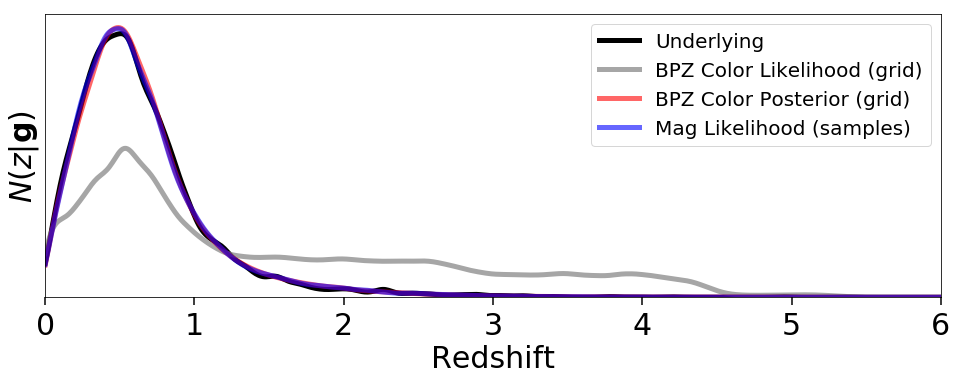

In [26]:
# true distribution
zpdf0 = frankenz.pdf.gauss_kde_dict(rdict, y=redshifts[test_sel],
                                    y_std=np.ones_like(test_sel) * rsmooth)

# plotting
plt.figure(figsize=(14, 6))
plt.plot(rdict.grid, zpdf0, lw=5, color='black',
         label='Underlying')
plt.plot(rdict.grid, pdfs_like.sum(axis=0), 
         lw=5, color='gray', alpha=0.7,
         label='BPZ Color Likelihood (grid)')
plt.plot(rdict.grid, pdfs_post.sum(axis=0), 
         lw=5, color='red', alpha=0.6, 
         label='BPZ Color Posterior (grid)')
plt.plot(rdict.grid, pdfs_train.sum(axis=0), 
         lw=5, color='blue', alpha=0.6,
         label='Mag Likelihood (samples)')
plt.xlim([0., 6.])
plt.ylim([0., None])
plt.yticks([])
plt.legend(fontsize=20)
plt.xlabel('Redshift')
plt.ylabel('$N(z|\mathbf{g})$')
plt.tight_layout()

We see that the population redshift distribution $N(z|\mathbf{g})$ computed from our noisy fluxes is very close to that computed by the (approximate) BPZ posterior (which is "correct" by construction). These both differ markedly from the color-based likelihoods computed over our noiseless grid, demonstrating the impact of the prior for data observed at moderate/low signal-to-noise (S/N).

# Comparison 2: Mag (samples) vs Color (samples)

Just for completeness, we also show the difference between computing our results using magnitudes (as above) vs color (with and without accounting for observational errors).

In [36]:
def lprob_train_c(x, xe, xm, ys, yes, yms):
    results = frankenz.pdf.loglike(x, xe, xm, ys, yes, yms,
                                   free_scale=True, 
                                   ignore_model_err=True)
    lnlike, ndim, chi2 = results
    return 0., lnlike, lnlike, ndim, chi2

def lprob_train_cerr(x, xe, xm, ys, yes, yms):
    results = frankenz.pdf.loglike(x, xe, xm, ys, yes, yms,
                                   free_scale=True, 
                                   ignore_model_err=False)
    lnlike, ndim, chi2 = results
    return 0., lnlike, lnlike, ndim, chi2

In [37]:
pdfs_train_c = train_BF.fit_predict(phot_test, err_test, mask_test,
                                    redshifts[train_sel], 
                                    np.ones_like(train_sel) * rsmooth,
                                    lprob_func=lprob_train_c, 
                                    label_dict=rdict, save_fits=False)

pdfs_train_cerr = train_BF.fit_predict(phot_test, err_test, mask_test,
                                       redshifts[train_sel], 
                                       np.ones_like(train_sel) * rsmooth,
                                       lprob_func=lprob_train_cerr,
                                       label_dict=rdict, save_fits=False)

Generating PDF 5000/5000
Generating PDF 5000/5000


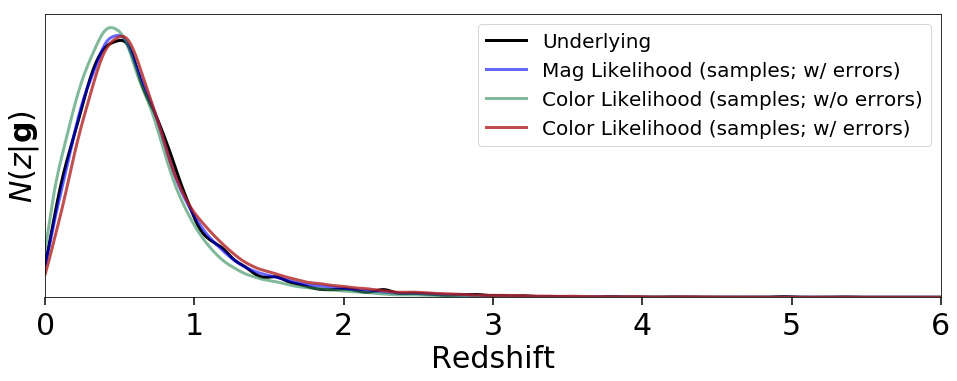

In [38]:
# plotting
plt.figure(figsize=(14, 6))
plt.plot(rdict.grid, zpdf0, lw=3, color='black',
         label='Underlying')
plt.plot(rdict.grid, pdfs_train.sum(axis=0),
         lw=3, color='blue', alpha=0.6,
         label='Mag Likelihood (samples; w/ errors)')
plt.plot(rdict.grid, pdfs_train_c.sum(axis=0),
         lw=3, color='seagreen', alpha=0.6,
         label='Color Likelihood (samples; w/o errors)')
plt.plot(rdict.grid, pdfs_train_cerr.sum(axis=0),
         lw=3, color='firebrick', alpha=0.8,
         label='Color Likelihood (samples; w/ errors)')
plt.xlim([0., 6.])
plt.ylim([0., None])
plt.yticks([])
plt.legend(fontsize=20)
plt.xlabel('Redshift')
plt.ylabel('$N(z|\mathbf{g})$')
plt.tight_layout()

Even among only a small number of objects, the difference between these two distributions is clear: **our color-based likelihoods are biased**. The differences are due to us "double counting" our prior: since our samples are drawn from the prior, the magnitude contains information. Using colors ignores this information. When we don't include errors, our fits for objects at fainter magnitudes become worse (on average), disfavoring those objects and biasing us to thse that are brighter (which are preferentially at lower redshifts). When we include errors, we can mitigate this effect, but then the larger population of objects at fainter magnitudes biases us (on average) towards higher redshifts. **Note that this effect is almost certainly exarcerbated in practice due to selection effects that bias training samples to include brighter galaxies at lower redshifts.**

# Individual PDF Accuracy

In addition to be good in aggregate, we can also test how well we can predict the redshifts of individual objects.

In [39]:
pdfs_train, gof = train_BF.fit_predict(phot_test, err_test, mask_test,
                                       redshifts[train_sel], 
                                       np.zeros_like(train_sel),  # no smoothing
                                       lprob_func=lprob_train, 
                                       label_dict=rdict,
                                       return_gof=True, save_fits=False)
lmap, levid = gof

Generating PDF 5000/5000


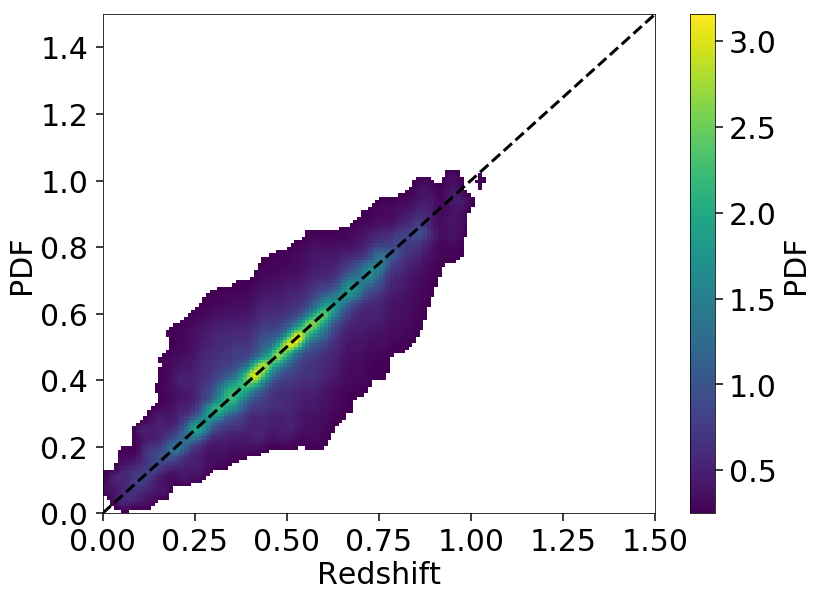

In [40]:
from frankenz import plotting as fzplot

# plot stacked PDFs
plt.figure(figsize=(12,9))
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_train, rdict, plot_thresh=0.25, smooth=1.5)
plt.xlabel('Redshift')
plt.ylabel('PDF')
plt.xlim([0., 1.5])
plt.ylim([0., 1.5])
plt.tight_layout()

Our individual PDFs look excellent: the distributions are almost exactly symmetric!

Finally, we can check the overall **coverage** of our PDFs to see how accurate they are individually. Since we have a set of MAP values $\max_h{\ln P(h|g)}$ associated with each fit along with a set of evidence values $\ln \mathcal{Z}_g$, we can first see what our overall coverage looks like.

NameError: name 'xlims' is not defined

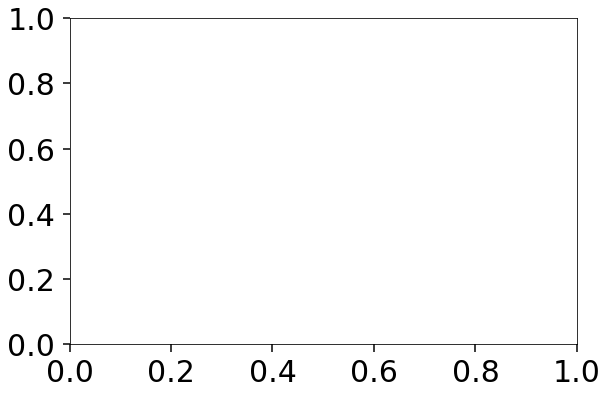

In [41]:
# plot chi2 distribution
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.hist(lmap, np.linspace(xlims[0], xlims[1], 50), 
         normed=True, cumulative=True)
plt.xlabel('Log(MAP)')
plt.ylabel('CDF')
plt.tight_layout()
plt.subplot(1,2,2)
plt.hist(levid, np.linspace(xlims[0], xlims[1], 50), 
         normed=True, cumulative=True)
plt.xlabel('Log(Evidence)')
plt.ylabel('CDF')
plt.tight_layout();

The two track each other, as expected. Now let's investigate the distribution of CDF values among our set of redshifts. For a truly unbiased result, we would expect this to be distributed uniformly. Finally, let's examine the distribution of CDF values. For "exact" PDFs, we would expect these to be distributed uniformly from 0 to 1.

In [ ]:
csel = ((levid > np.sort(levid)[int(0.05 * Ntest)]) &
        (lmap > np.sort(lmap)[int(0.05 * Ntest)])) # flag bad fits
print(sum(csel) * 1. / len(csel))  # check overlap between levid/lmap cuts

# plot results
plt.figure(figsize=(16, 7))
plt.subplot(121)
fzplot.cdf_vs_epdf(redshifts[test_sel], np.zeros_like(test_sel),
                   pdfs_train, rdict.grid, 
                   plot_kwargs={'color': 'blue', 'alpha': 0.2})
fzplot.cdf_vs_epdf(redshifts[test_sel], np.zeros_like(test_sel),
                   pdfs_train, rdict.grid, weights=csel,
                   plot_kwargs={'color': 'red', 'alpha': 0.6})
plt.hlines(1., 0., 1., colors='black', lw=4, alpha=0.8,
           linestyles='--')  # best-case result
plt.tight_layout()
plt.subplot(122)
fzplot.cdf_vs_ecdf(redshifts[test_sel], np.zeros_like(test_sel),
                   pdfs_train, rdict.grid, 
                   plot_kwargs={'color': 'blue', 'alpha': 0.8, 'lw': 3})
fzplot.cdf_vs_ecdf(redshifts[test_sel], np.zeros_like(test_sel),
                   pdfs_train, rdict.grid, weights=csel,
                   plot_kwargs={'color': 'red', 'alpha': 0.8, 'lw': 3})
plt.plot([0, 1], [0, 1], lw=3, color='black', ls='--')
plt.legend(['All objects', 'Bad fits removed', 'Uniform'], loc='best', fontsize=18)
plt.tight_layout()

Our sample-based redshift PDFs agree reasonably well with the theoretical expectation.